# Word2Vec 文本分类

In [44]:
import os
import numpy.random
import torch.cuda
import wordcloud
import jieba
import csv
import jieba.analyse
import jieba.posseg
from imageio import imread
import jiagu
from aip import AipNlp
import json
from collections import defaultdict, OrderedDict
import time
import re
from gensim.models import word2vec
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## 固定随机数

In [3]:
numpy.random.seed(100)
torch.cuda.manual_seed(100)

In [35]:
import os
class_list = os.listdir("./data")
rate = 0.7

## 对每个类别，依次读取类型文本，分词保存到.txt文件

In [37]:
def single(file):
    file = open(file, "rt", encoding='utf-8')
    content = file.read()
    # content = clean2(content)   # 先仅保留中文
    word_list = jieba.analyse.textrank(content, topK = None, withWeight= False, allowPOS=("ns", "n", "vn", "v"))
    # all_words.extend(word_list)  # 整合所有的词
    # txt = " ".join(word_list) # 返回字符串
    return word_list

In [ ]:
def all(type):
    path = "./data/" + type
    cf1 = open("./result/" + type +"/"+ type + "-corpus.txt", "w", encoding="utf-8")
    cf2 = open("./result/" + type + "/"+ type +"-words.txt", "w", encoding="utf-8")
    file_list = os.listdir(path)
    # all_words = []
    for f in file_list:  # 对每个类别的文本，分词整合
        single_path = path + "/" + f
        tmp = single(single_path)
        cf1.write(" ".join(tmp) + " ")
        cf2.write(" ".join(tmp) + "\n")
    cf1.close()
    cf2.close()
    
for c in class_list:
    all(c)

## 整合获得all.txt 所有文本的分词结果，训练获取词向量模型

In [ ]:
fa = open("./result/all.txt", "w", encoding="utf-8")
for c in class_list:
    file = "./result/" + c + "/"+ c + "-corpus.txt"
    f = open(file, "r", encoding="utf-8")
    con = f.read()
    f.close()
    fa.write(con + "  ")
fa.close()


## 训练词向量

In [ ]:
sentences = word2vec.Text8Corpus("./result/all.txt")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = word2vec.Word2Vec(sentences, vector_size= 200, min_count=1)
model.save("./result/" "all_model.model")

## 加载词向量

In [31]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("./result/all_model.model")

## 获取每个类别前70%的文本词汇

In [32]:
def ratetrain(type):
    path = "./data/" + type
    file_list = os.listdir(path)
    all_words = []
    for f in file_list[:int(len(file_list) * rate)]:
        single_path = path + "/" + f
        tmp = single(single_path)
        all_words.extend(tmp)
    return all_words

## 组建训练文本（每个类别前70%txt）的词频字典

In [40]:
class_all_words = {}
for c in class_list:
    all_words = {}
    wl = ratetrain(c)
    for w in wl:
        if len(w) != 1:
            all_words[w] = all_words.get(w, 0) + 1
    items = list(all_words.items())
    items.sort(key=lambda x:x[1], reverse=True)  # 排序
    class_all_words[c] = all_words
all_class_words =  class_all_words

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.702 seconds.
Prefix dict has been built successfully.


## 对训练集（70% txt）计算平均词向量（200维），作为训练集的特征向量

## 可以决定选用多少个 排序后的最大频数（sorted）的关键词（textrank）词向量

## 得到训练数据的特征字典，包含了七个类别的平均特征向量

## 后续的文本，可以依次对比与哪一类别的向量更相似

In [41]:
def average_class_vector(key_num): # 决定选用多少个最大频数(sort)的关键词（texkrank）
    average_class_dic = {}
    for c in class_list:
        class_words_list = sorted(all_class_words[c].items(), key = lambda x:x[1], reverse=True)
        total_vector = 0
        if key_num > len(class_words_list):
            for w in range(len(class_words_list)):
                total_vector += model.wv[class_words_list[w][0]] # 返回200维的向量
        else:
            for w in range(key_num):
                total_vector += model.wv[class_words_list[w][0]]

        average_class_dic[c] = total_vector / key_num  # 统计一个平均的200维度的向量，来代表70%的文本的特征关键词特征
    return average_class_dic  # 包含了七个类别的特征向量


## 预测类别

In [42]:
def predict(data):
    class_similarity = {}
    for c in class_list:
        class_similarity[c] = cos_similarity(data, average_class_v[c])
    test_similarity_list = sorted(class_similarity.items(), key=lambda x:x[1], reverse=True) # 按照余弦相似度排序
    return test_similarity_list[0][0]  # 排序之后，返回最大相似度的类别
def cos_similarity(a, b):  # 计算余弦相似度,表示文本之间的相似程度
    a = np.array(a)
    b = np.array(b)
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    similarity = np.dot(a, b) / (a_norm * b_norm)
    return similarity

## 对每个类别的测试集（后30%txt），依次计算与哪一类别的特征向量更相近，余弦相似度最大者，为预测结果

In [43]:
def accuracy(key_num):
    tru = 0
    fal = 0
    for c in tqdm(class_list):
        print(c)
        path = "./data/" + c
        file_list = os.listdir(path)
        for f in file_list[int(len(file_list) * rate):]:
            file_words = {}
            single_path = path + "/" + f
            tmp = single(single_path)
            for w in tmp:
                if len(w) != 1:
                    file_words[w] = file_words.get(w, 0) + 1
            items = sorted(file_words.items(), key=lambda x: x[1], reverse=True)
            tmp = 0
            if key_num > len(items):
                for t in range(len(items)):
                    tmp += model.wv[items[t][0]]  # 返回200维的向量
            else:
                for t in range(key_num):
                    tmp += model.wv[items[t][0]]
            ave = tmp / key_num
            res = predict(ave)
            if res == c:
                tru += 1
            else:
                fal += 1
    return tru / (tru + fal)


In [71]:
acc_l = []

## 选用1个关键词

In [72]:
key_num = 1
average_class_v = average_class_vector(key_num)
acc_l.append(round(accuracy(key_num), 5))


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:35,  5.99s/it]

房产



 29%|██▊       | 2/7 [00:07<00:17,  3.57s/it]

教育



 43%|████▎     | 3/7 [00:11<00:13,  3.44s/it]

时尚



 57%|█████▋    | 4/7 [00:12<00:07,  2.60s/it]

时政



 71%|███████▏  | 5/7 [00:14<00:04,  2.37s/it]

科技



 86%|████████▌ | 6/7 [00:16<00:02,  2.31s/it]

财经


100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


In [73]:
print(acc_l)

[0.28741]


## 选用3个关键词

In [74]:
key_num = 3
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))



  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:33,  5.57s/it]

房产



 29%|██▊       | 2/7 [00:07<00:17,  3.42s/it]

教育



 43%|████▎     | 3/7 [00:11<00:14,  3.69s/it]

时尚



 57%|█████▋    | 4/7 [00:13<00:08,  2.88s/it]

时政



 71%|███████▏  | 5/7 [00:15<00:05,  2.62s/it]

科技



 86%|████████▌ | 6/7 [00:17<00:02,  2.48s/it]

财经


100%|██████████| 7/7 [00:19<00:00,  2.85s/it]


In [75]:
print(acc_l)

[0.28741, 0.4038]


## 选用5个关键词

In [76]:
key_num = 5
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:32,  5.34s/it]

房产



 29%|██▊       | 2/7 [00:07<00:16,  3.29s/it]

教育



 43%|████▎     | 3/7 [00:10<00:12,  3.13s/it]

时尚



 57%|█████▋    | 4/7 [00:11<00:07,  2.44s/it]

时政



 71%|███████▏  | 5/7 [00:13<00:04,  2.28s/it]

科技



 86%|████████▌ | 6/7 [00:15<00:02,  2.27s/it]

财经


100%|██████████| 7/7 [00:18<00:00,  2.57s/it]


In [77]:
print(acc_l)

[0.28741, 0.4038, 0.42993]


## 选用10个关键词

In [78]:
key_num = 10
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:33,  5.53s/it]

房产



 29%|██▊       | 2/7 [00:07<00:16,  3.37s/it]

教育



 43%|████▎     | 3/7 [00:10<00:12,  3.12s/it]

时尚



 57%|█████▋    | 4/7 [00:11<00:07,  2.44s/it]

时政



 71%|███████▏  | 5/7 [00:13<00:04,  2.30s/it]

科技



 86%|████████▌ | 6/7 [00:15<00:02,  2.29s/it]

财经


100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


In [79]:
print(acc_l)

[0.28741, 0.4038, 0.42993, 0.57957]


## 选用15个关键词

In [80]:
key_num = 15
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))
print(acc_l)


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:33,  5.61s/it]

房产



 29%|██▊       | 2/7 [00:07<00:17,  3.52s/it]

教育



 43%|████▎     | 3/7 [00:10<00:12,  3.24s/it]

时尚



 57%|█████▋    | 4/7 [00:11<00:07,  2.51s/it]

时政



 71%|███████▏  | 5/7 [00:13<00:04,  2.33s/it]

科技



 86%|████████▌ | 6/7 [00:16<00:02,  2.28s/it]

财经


100%|██████████| 7/7 [00:18<00:00,  2.65s/it]

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095]


In [81]:
print(acc_l)

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095]


## 选用20个关键词

In [82]:
key_num = 20
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))
print(acc_l)


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:06<00:37,  6.21s/it]

房产



 29%|██▊       | 2/7 [00:08<00:20,  4.04s/it]

教育



 43%|████▎     | 3/7 [00:11<00:14,  3.68s/it]

时尚



 57%|█████▋    | 4/7 [00:13<00:08,  2.86s/it]

时政



 71%|███████▏  | 5/7 [00:15<00:05,  2.56s/it]

科技



 86%|████████▌ | 6/7 [00:17<00:02,  2.48s/it]

财经


100%|██████████| 7/7 [00:20<00:00,  2.90s/it]

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371]


In [83]:
print(acc_l)

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371]


## 选用30个关键词

In [84]:
key_num = 30
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))
print(acc_l)


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:06<00:36,  6.15s/it]

房产



 29%|██▊       | 2/7 [00:08<00:18,  3.77s/it]

教育



 43%|████▎     | 3/7 [00:12<00:15,  3.80s/it]

时尚



 57%|█████▋    | 4/7 [00:13<00:09,  3.03s/it]

时政



 71%|███████▏  | 5/7 [00:16<00:05,  2.95s/it]

科技



 86%|████████▌ | 6/7 [00:19<00:02,  2.79s/it]

财经


100%|██████████| 7/7 [00:21<00:00,  3.11s/it]

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458]


In [85]:
print(acc_l)

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458]


## 选用50个关键词

In [86]:
key_num = 50
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))
print(acc_l)


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:33,  5.64s/it]

房产



 29%|██▊       | 2/7 [00:07<00:17,  3.48s/it]

教育



 43%|████▎     | 3/7 [00:10<00:12,  3.25s/it]

时尚



 57%|█████▋    | 4/7 [00:11<00:07,  2.52s/it]

时政



 71%|███████▏  | 5/7 [00:13<00:04,  2.33s/it]

科技



 86%|████████▌ | 6/7 [00:16<00:02,  2.27s/it]

财经


100%|██████████| 7/7 [00:18<00:00,  2.63s/it]

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458, 0.74822]


In [87]:
print(acc_l)

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458, 0.74822]


## 选用100个关键词

In [91]:
acc_l =[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458, 0.74822]

In [92]:
key_num = 100
average_class_v = average_class_vector(key_num)
#print(round(accuracy(key_num), 5))
acc_l.append(round(accuracy(key_num), 5))
print(acc_l)


  0%|          | 0/7 [00:00<?, ?it/s]

家居



 14%|█▍        | 1/7 [00:05<00:34,  5.71s/it]

房产



 29%|██▊       | 2/7 [00:07<00:17,  3.52s/it]

教育



 43%|████▎     | 3/7 [00:11<00:14,  3.51s/it]

时尚



 57%|█████▋    | 4/7 [00:12<00:08,  2.70s/it]

时政



 71%|███████▏  | 5/7 [00:14<00:05,  2.52s/it]

科技



 86%|████████▌ | 6/7 [00:17<00:02,  2.48s/it]

财经


100%|██████████| 7/7 [00:19<00:00,  2.83s/it]

[0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458, 0.74822, 0.73397]


In [ ]:
print(acc_l)

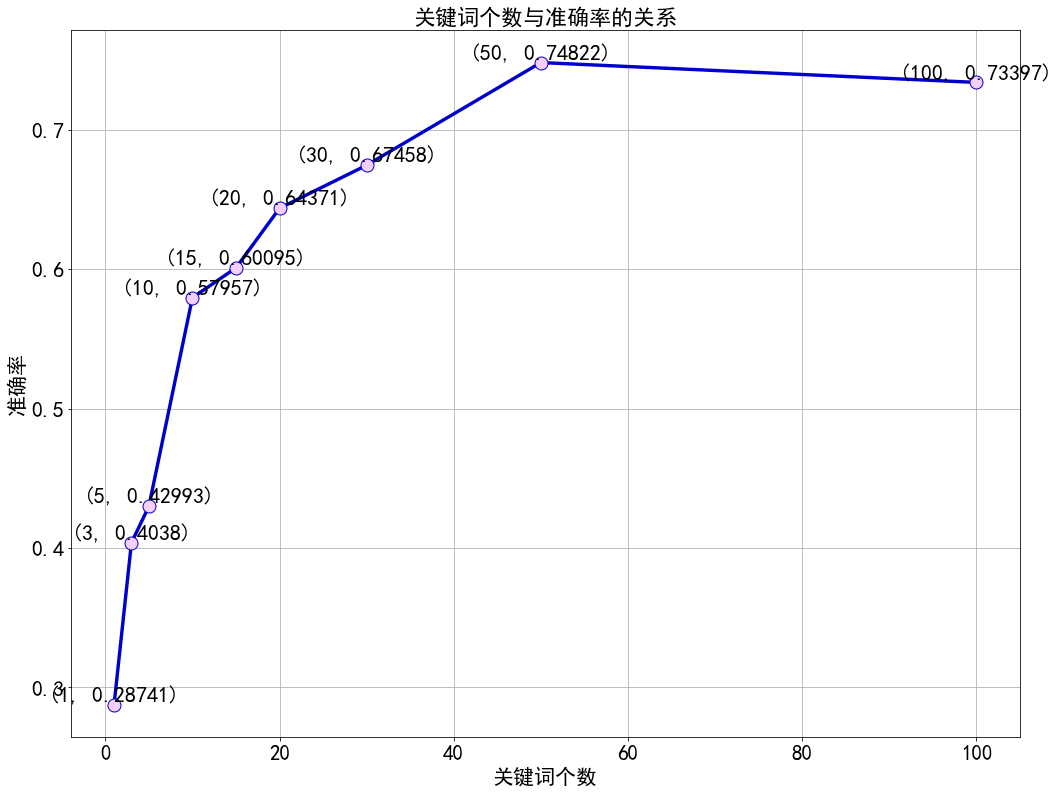

In [166]:
import matplotlib.pyplot as plt
key_num_l = [1,3,5,10,15,20,30,50,100]
acc_l = [0.28741, 0.4038, 0.42993, 0.57957, 0.60095, 0.64371, 0.67458, 0.74822, 0.73397]
fig = plt.figure(figsize=(17,13))
plt.plot(key_num_l, acc_l, color = "#0000CD", markerfacecolor = "#f6cefc", linewidth = 3.4, markersize = 13,  marker = "o")

for a, b in zip(key_num_l, acc_l):
    plt.text(a, b,(a,b),ha = 'center', va = "bottom", fontsize = 22)
    
plt.title('关键词个数与准确率的关系', fontsize = 22)
plt.xlabel('关键词个数',fontsize = 21)
plt.ylabel('准确率', fontsize = 21)
plt.tick_params(axis = 'both', which = 'major', labelsize = 22)
plt.tick_params(axis = 'x', which = 'major', labelsize = 21)
ax = plt.gca()
plt.grid()
plt.show()

## 使用Weibo-search 爬取博文，特定关键词为“离婚冷静期”

## 爬取到的博文，格式如下，包含用户信息，博文内容，互动信息等，存在csv文件中

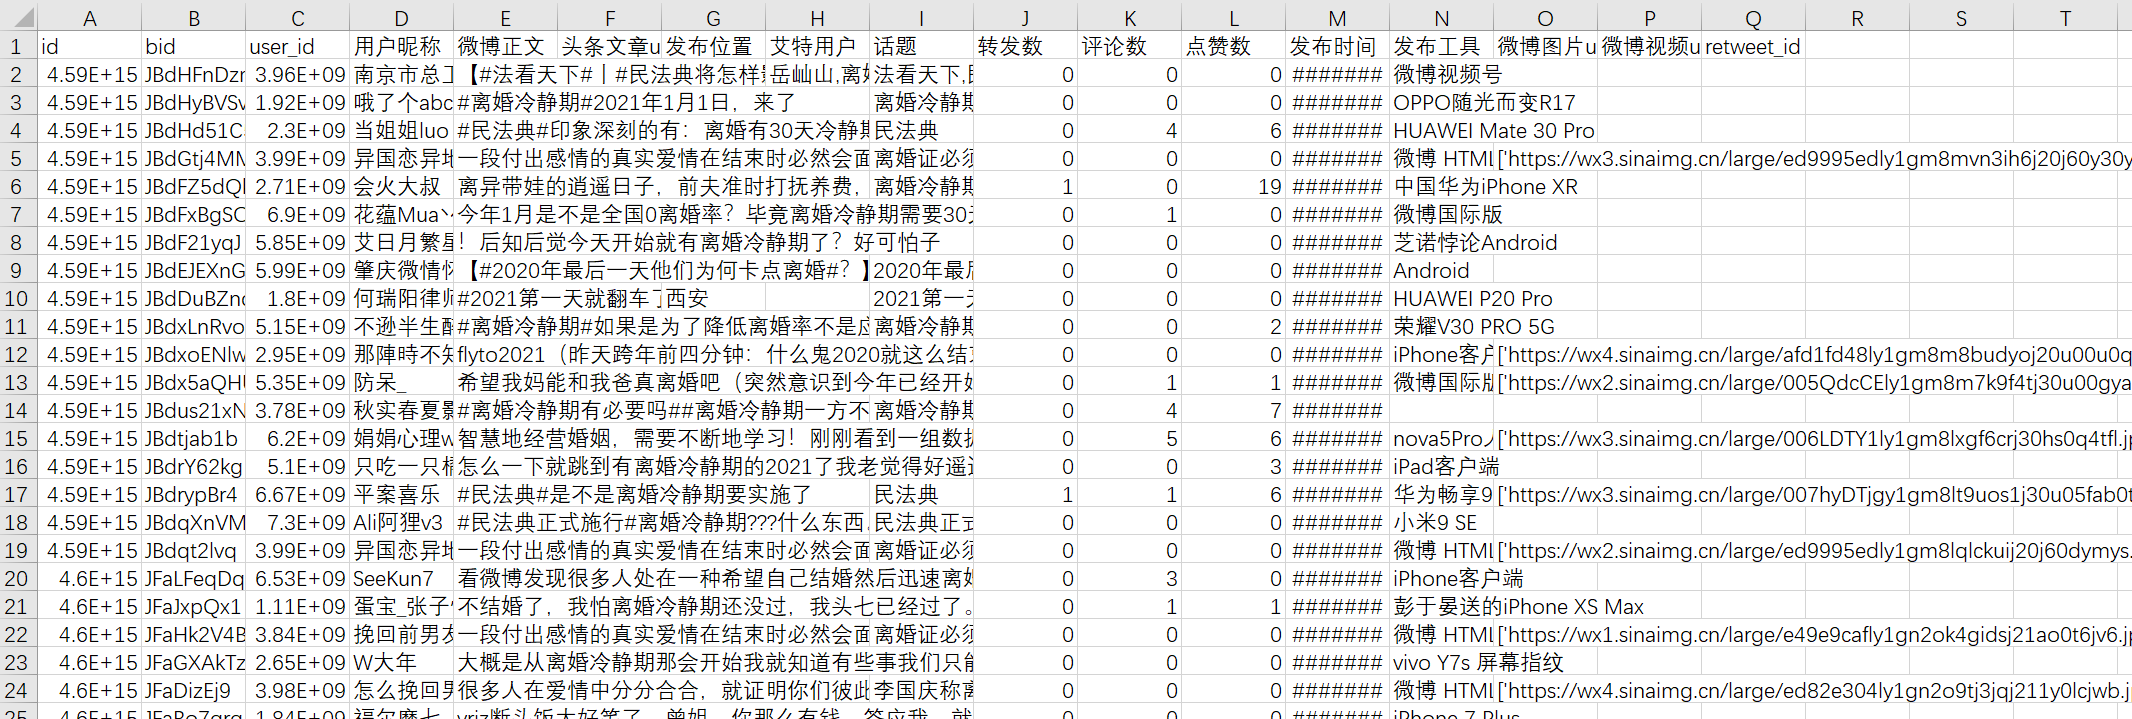

## 对爬取数据处理，将博文内容提取

### 去除博文的话题、用户回复，将csv文件所有博文读取，写入txt文件

In [ ]:
def clean2(str):
    comp = re.compile('#[^#]+#') # 仅保留中文
    comp2 = re.compile('@[^,，：:\s@]+')
    # comp3 = re.compile('【[^】]+】')
    comp4 = re.compile('《^》]+》')
    str = comp.sub('', str)
    str = comp2.sub('',str)
    # str = comp3.sub('',str)
    str = comp4.sub('', str)
    return str

In [ ]:
ofile = "离婚冷静期" 

In [ ]:
def get_tweets(datafile, tweetfile):
    num = 0
    csvfile = open(datafile ,'rt', encoding='utf-8')
    tweets = open(tweetfile, "w", encoding='utf-8')
    reader = csv.reader(csvfile)
    column = [row[4] for row in reader]
    for item in column:
        num = num + 1
        print(num, item)
        item = clean2(item) # 去除话题
        tweets.write(item + '\n')
    csvfile.close()
    tweets.close()

    
print('-' * 40)
print("读取博文")
get_tweets(ofile + ".csv", ofile + ".txt")  # 将csv文件所有博文读取 写入 txt文件

## 配置Baidu 审核远端调用

In [ ]:
""" 你的 APPID AK SK """
# 创建实例，获得如下接口调用信息
APP_ID = '' # 填入AppID
API_KEY = '' # 填入API_Key
SECRET_KEY = '' # 填入Secret_Key
client = AipContentCensor(APP_ID, API_KEY, SECRET_KEY)


## 调用远程审核，将结果写入csv、json文件

## 由于Baidu调用速率，远端访问可能不太稳定，对于大量数据处理，需要sleep控制，并且记录断开后重新开始的位置

In [ ]:

def censor_baidu(tweetfile, sentijson, senticsv):
    tweets = open(tweetfile, 'r', encoding='utf-8')
    tweets_lines = tweets.readlines()
    tmp_list = []
    tmp_count = 0
    count_num = 0 # 如果与远端断开了，可以根据已完成情况，修改此变量，即可继续分析
    empty = ''
    connect_num = 0
    for tweet_line in tweets_lines[count_num:]:
        # 计算情感倾向
        # 如果是追加，先获取json中的列表
        if count_num != 0:
            tmp_json = open(sentijson, 'r', encoding='utf-8')
            tmp_list = json.load(tmp_json)
            tmp_json.close()

        # 避免发出请求过多被中断，每隔一段时间，暂停一下
        if connect_num <= 1500:
            connect_num = connect_num + 1
        else:
            connect_num = 0
            time.sleep(15)

        # 请求远端
        tweet_line = str(tweet_line.strip())
        re = client.textCensorUserDefined(tweet_line)

        # 如果是error 则跳过，error是因为博文长度过长，跳过
        if re.get('error_code', "Not Available") != "Not Available" :
            continue

        # 写入json 文件
        count_num = count_num + 1
        print(count_num, re)
        sjw = open(sentijson,'w',encoding='utf-8')
        tmp_list.append(re)
        json.dump(tmp_list, sjw, indent = 4,ensure_ascii=False)
        sjw.close()

        # 写入csv文件
        sc = open(senticsv, 'a', encoding='utf-8-sig',newline='')
        senti_writer = csv.writer(sc)
        if (re['conclusionType'] == 1):  # 合规
            senti_writer.writerow([re['conclusionType'], re['conclusion'],empty, tweet_line])
        if (re['conclusionType'] == 2): # 不合规，记录原因
            senti_writer.writerow([re['conclusionType'], re['conclusion'], re['data'][0]['msg'], tweet_line])
        sc.close()

       
        # 控制QPS
        tmp_count += 1
        if tmp_count == 2 :
            time.sleep(1)
            tmp_count = 0

## 所有博文审核完成

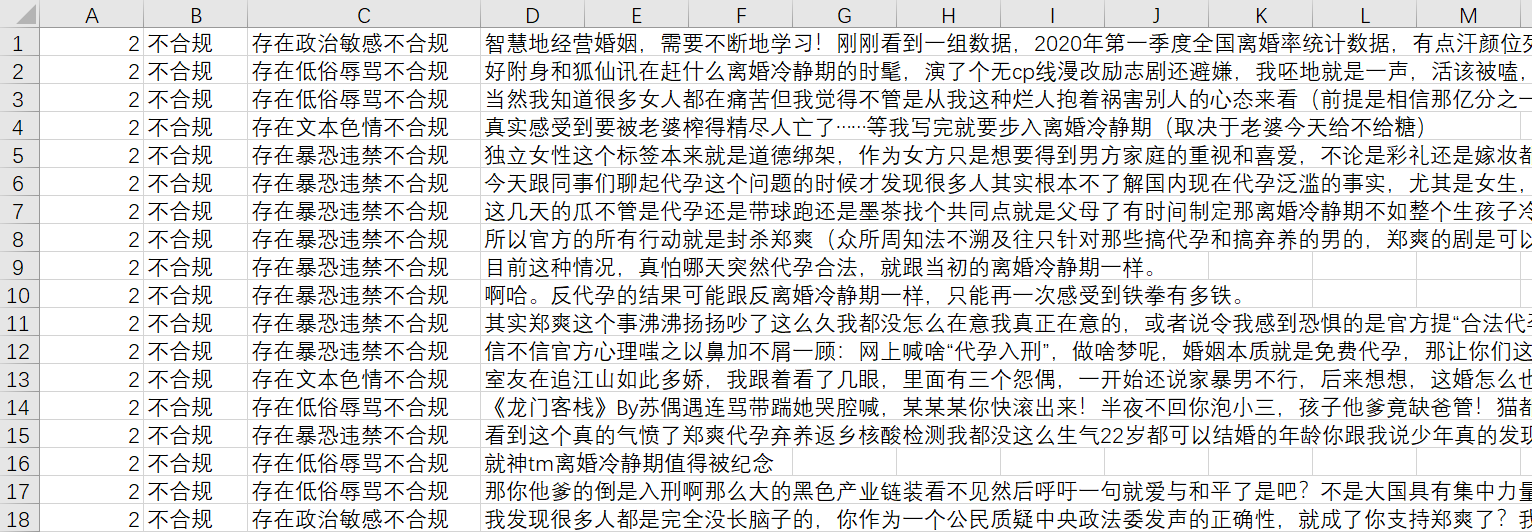

## 对审核结果统计分析

In [9]:
import csv

f = open("离婚冷静期_new_results.csv", "r", encoding="utf-8")
r= csv.reader(f)
types = []
ilt = []
for row in r:
    types.append(row[0])
    ilt.append(row[2])
l = 0
il = 0
type_dic = {}
for i in types:
    if ('1' in i):
        l = l + 1
    if ( '2' in i):
        il = il + 1
for item in ilt:
    if item != "":
        type_dic[item] = type_dic.get(item, 0) + 1
print(type_dic)
print("total posts: ", len(types))
print("legal posts: ", l, round(l/len(types), 5))
print('illegal posts: ', il, round(il/len(types), 5))


{'存在政治敏感不合规': 187, '存在低俗辱骂不合规': 575, '存在文本色情不合规': 107, '存在暴恐违禁不合规': 669, '存在恶意推广不合规': 401, '存在百度官方默认违禁词库不合规': 26}
total posts:  17360
legal posts:  15395 0.88681
illegal posts:  1965 0.11319


dict_keys(['存在政治敏感不合规', '存在低俗辱骂不合规', '存在文本色情不合规', '存在暴恐违禁不合规', '存在恶意推广不合规', '存在百度官方默认违禁词库不合规'])
dict_values([187, 575, 107, 669, 401, 26])


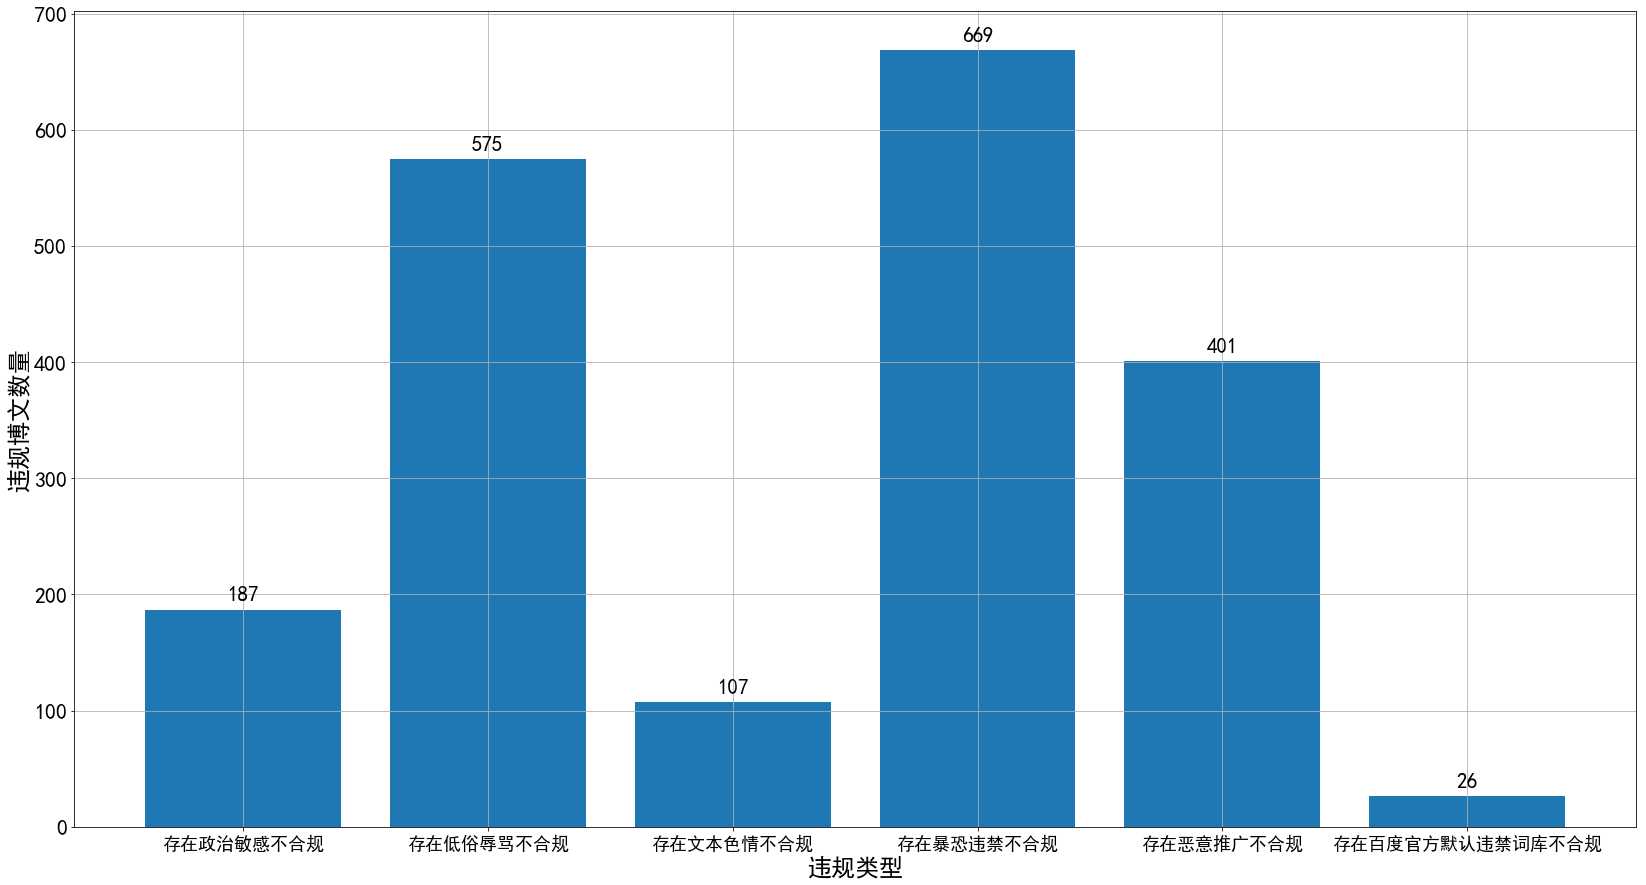

In [60]:
badtypes = type_dic.keys()
badnum = type_dic.values()
print(badtypes)
print(badnum)

import matplotlib.pyplot as plt
plt.figure(figsize=(28,15))
plt.bar(badtypes, badnum)
ax = plt.gca()
plt.tick_params(axis = 'both', which = 'major', labelsize = 22)
plt.tick_params(axis = 'x', which = 'major', labelsize = 18)
plt.ylabel('违规博文数量',fontsize = 24)
plt.xlabel('违规类型', fontsize = 24)

for a,b in zip(badtypes,badnum):
    plt.text(a, b+5,b, ha = 'center',va = 'bottom',fontsize=21)
plt.grid()
plt.show()